**Goal:** Analyze the results of the first experimentation stage (fine-tuning of sentence embedding models).

In [ ]:
import json
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
COMPETITION_PATH = "../competition"

MODEL_ALIASES = {
    "paraphrase-MiniLM-L3-v2": "pml3",
    "all-mpnet-base-v2": "amb",
    "all-MiniLM-L6-v2": "aml6",
    "paraphrase-albert-small-v2": "pas",
    "all-distilroberta-v1": "adr",
    "baseline": "baseline.json"
}

aliases = {v: k for k, v in MODEL_ALIASES.items()}

In [3]:
results = []

for file_name in os.listdir(COMPETITION_PATH):
    if file_name.endswith(".json"):
        file_path = os.path.join(COMPETITION_PATH, file_name)
        with open(file_path, "r") as json_file:
            try:
                data = json.load(json_file)
                data["experiment"] = file_name 
                results.append(data)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON from file {file_name}: {e}")

In [ ]:
results_df = pd.DataFrame(results)
results_df = results_df.loc[results_df["experiment"] != "baseline_.json"]
results_df["model"] = results_df["experiment"].apply(lambda x: aliases[x.split("-")[0]])
results_df["iterations"] = results_df["experiment"].apply(lambda x: int(x.split("-")[1].replace("i", "")) if x != "baseline.json" else 20)

In [ ]:
max_avg_runtime = 5
max_avg_flops = 5000

# Calculate submission score
results_df["avg_f1_w"] = 0.6 * results_df["avg_f1"]
results_df["avg_runtime_w"] = 0.2 * (max_avg_runtime - results_df["avg_runtime"]) / max_avg_runtime
results_df["avg_flops_w"] = 0.2 * (max_avg_flops - results_df["avg_flops"]) / max_avg_flops
results_df["submission_score"] = results_df["avg_f1_w"] + results_df["avg_runtime_w"] + results_df["avg_flops_w"]

In [11]:
results_df[["model", "iterations", "avg_f1", "avg_runtime", "avg_flops", "submission_score"]].sort_values(by=["model", "iterations"])

,model,iterations,avg_f1,avg_runtime,avg_flops,submission_score
1,all-MiniLM-L6-v2,20,0.642462,1.346752,2173.297567,0.644675
9,all-MiniLM-L6-v2,40,0.647586,1.292057,2173.297567,0.649937
12,all-MiniLM-L6-v2,60,0.657836,1.267431,2173.297567,0.657072
7,all-distilroberta-v1,20,0.649909,1.559863,8997.904873,0.367635
2,all-distilroberta-v1,40,0.655935,1.706267,8997.904873,0.365394
4,all-distilroberta-v1,60,0.658464,1.565327,8997.904873,0.372549
6,all-mpnet-base-v2,20,0.692095,3.533943,18489.307337,-0.065673
14,all-mpnet-base-v2,40,0.679473,2.662580,18489.307337,-0.038391
11,all-mpnet-base-v2,60,0.656421,2.318259,18489.307337,-0.038450
15,baseline,20,0.639364,0.942169,999.027143,0.705970


In [7]:
agg_results_df = results_df.groupby("model")[["avg_f1_w", "avg_runtime_w", "avg_flops_w", "submission_score"]].mean()
agg_results_df = agg_results_df.sort_values("submission_score", ascending=False)
agg_results_df = agg_results_df.reset_index()

In [8]:
agg_results_df

,model,avg_f1_w,avg_runtime_w,avg_flops_w,submission_score
0,baseline,0.383618,0.162313,0.160039,0.705970
1,paraphrase-MiniLM-L3-v2,0.376738,0.157435,0.160039,0.694211
2,all-MiniLM-L6-v2,0.389577,0.147917,0.113068,0.650562
3,paraphrase-albert-small-v2,0.382945,0.133243,-0.123540,0.392648
4,all-distilroberta-v1,0.392862,0.135581,-0.159916,0.368526
5,all-mpnet-base-v2,0.405598,0.086470,-0.539572,-0.047505


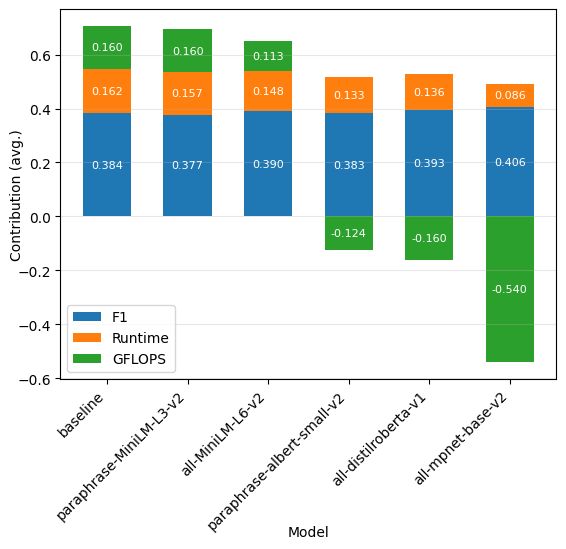

In [9]:
def func(row):
    """Handles the positioning of negative contributions"""
    if row["avg_flops_w"] > 0:
        return row["avg_f1_w"] + row["avg_runtime_w"]
    else:
        return 0

# Calculate the bottom of each stack
agg_results_df["avg_f1_w_bottom"] = 0
agg_results_df["avg_runtime_w_bottom"] = agg_results_df["avg_f1_w"]
agg_results_df["avg_flops_w_bottom"] = agg_results_df.apply(func, axis=1)

# Create the plot
bar_width = 0.6
plt.bar(agg_results_df["model"], agg_results_df["avg_f1_w"], label="F1", width=bar_width)
plt.bar(agg_results_df["model"], agg_results_df["avg_runtime_w"], bottom=agg_results_df["avg_runtime_w_bottom"], label="Runtime", width=bar_width)
plt.bar(agg_results_df["model"], agg_results_df["avg_flops_w"], bottom=agg_results_df["avg_flops_w_bottom"], label="GFLOPS", width=bar_width)

# Add labels to each bar section
for i, model in enumerate(agg_results_df["model"]):
    # F1
    plt.text(i, agg_results_df.loc[i, "avg_f1_w"] / 2, f"{agg_results_df.loc[i, 'avg_f1_w']:.3f}",  ha="center", va="center", color="white", fontsize=8)

    # Runtime
    runtime_height = agg_results_df.loc[i, "avg_runtime_w"]
    runtime_bottom = agg_results_df.loc[i, "avg_runtime_w_bottom"]
    plt.text(i, runtime_bottom + runtime_height / 2, f"{runtime_height:.3f}", ha="center", va="center", color="white", fontsize=8)

    # GFLOPS
    flops_height = agg_results_df.loc[i, "avg_flops_w"]
    flops_bottom = agg_results_df.loc[i, "avg_flops_w_bottom"]
    plt.text(i, flops_bottom + flops_height / 2, f"{flops_height:.3f}", ha="center", va="center", color="white", fontsize=8)

# plt.title("Sumbission score by model", pad=25)
plt.xlabel("Model", labelpad=-5)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Contribution (avg.)", labelpad=-5)
plt.legend()
plt.grid(axis="y", alpha=0.3)

plt.show()